Source: [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning) and [Some example](http://dni-institute.in/blogs/gini-index-work-out-example/).

## Decision Tree

[Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning) is one of the simplest and most effective algorithm for classification and regression. Can be used on both numerical and categorical-type dataset.

The most common ones are ID3, C4.5, CART (Classification And Regression Tree), CHAID (CHi-squared Automatic Interaction Detector), and MARS.

The key idea is to have decision "fork" and branches out in a tree strucure, finally arriving at a good degree of segregation between classes. We do have to define a metric that can select good features for us to branch out.

![img](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

## Metrics

We are going to use [Information Gain](https://en.wikipedia.org/wiki/Decision_tree_learning#Information_gain) for this example. 

Let $ f_i $ be the fraction of data points labeled as class $ i $ in the dataset.

Entropy $H$ is

$$ H(f) = - \sum_{i} f_i \cdot log_2 f_i $$

Information Gain $G$ is = Entropy(Parent) - Weighted sum of Entropy(children)

$$ G(T,a) = H(T) - \frac{1}{N} \sum_{a = 1}^N H(T \vert a) $$

We want to minimize this metric for each chosen cutoff-point.

## Coding

From 2D dataset, this is going to be a simple 2-layer tree.

2 decision nodes (either start at X0 or X1 first) then 4 leaf nodes (the final prediction of class 0 or 1)

...

..

.

In [244]:
import pandas as pd
import numpy as np
from random import randint
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Make Random dataset.

Source: http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html

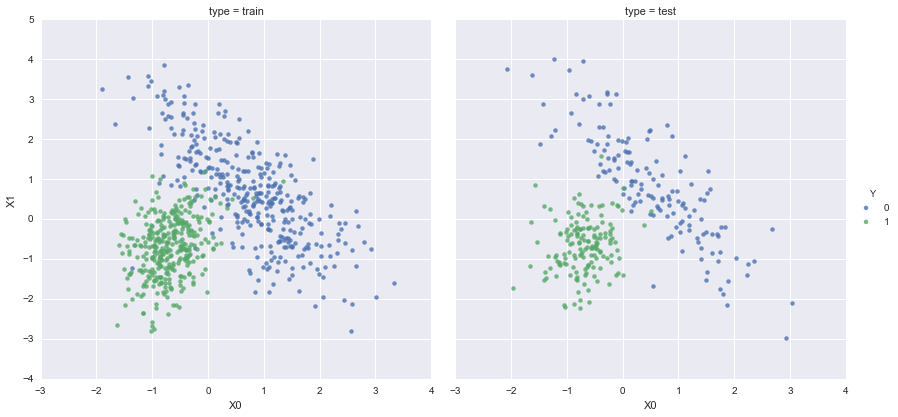

In [263]:
from sklearn.datasets import make_classification

df = pd.DataFrame(columns=['X0','X1','Y'])
X, Y = make_classification(n_samples=1000, n_features=2, class_sep=0.7, hypercube=True, \
                           n_informative=2, n_redundant=0, n_classes=2, n_clusters_per_class=1)
train_test_split = 0.7
train_size = int(X.shape[0]*train_test_split) 
test_size = X.shape[0] - train_size
X_train,Y_train,X_test,Y_test = X[0:train_size],Y[0:train_size],X[train_size:],Y[train_size:] 
df['X0'],df['X1'],df['Y'] = X[:, 0],X[:, 1],Y
df['type'] = 'train'
df.loc[train_size:,'type'] = 'test'

#plt.title("four clusters", fontsize='small')
#plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y)
sns.lmplot(x='X0',y='X1',data=df,hue='Y',fit_reg=False, col='type', size=6)

In [264]:
from math import log
def entropy(Y):
    if (len(Y) == 0):
        return 0
    p = np.count_nonzero(Y)*1.0/Y.shape[0]
    if(p == 0 or p == 1):
        return 0
    else:
        return -p*log(p,2) -(1-p)*log(1-p,2)
def find_cutoff(X,Y, split_size):
    # search tree, try 5 cutoff points, each axis
    X_min = np.min(X)
    X_max = np.max(X)

    E_root = entropy(Y)
    E_X_best = E_root
    X_cutoff_best = 0.0
    print 'X_min = {:.2f},X_max = {:.2f}'.format(X_min,X_max)
    print 'root entropy = {:.3f}'.format(E_root)
    for i in range(0,split_size):
        X_cutoff_point = round(X_min + (X_max - X_min)/(split_size+1)*(i+1),3)

        index_lower = (X < X_cutoff_point)
        index_higer = np.logical_not(index_lower)
        len_lower,len_higher = len(Y[index_lower]),len(Y[index_higer])
        len_all = len_lower + len_higher

        E_lower = entropy(Y[index_lower])
        E_higher = entropy(Y[index_higer])

        E_X = 1.0*len_lower/len_all*E_lower + 1.0*len_higher/len_all*E_higher

        if(E_X < E_X_best):
            E_X_best = E_X
            X_cutoff_best = X_cutoff_point
            
    print 'Chosen X cut_off = {:.2f}, E = {:.3f}'.format(X_cutoff_best,E_X_best)
    print ''
    return X_cutoff_best,E_X_best

Start with X0 split, then X1 split.

Calculate final entropy.

In [265]:
# search tree, try 5 cutoff points, each axis
# Test X0 first
print 'X0'
L0_cut,E_L0 = find_cutoff(X_train[:,0],Y_train,5)
index_left = (X_train[:,0] < L0_cut)
index_right = np.logical_not(index_left)

#X0 left side, Test X1
print 'X1 for X0 left side'
L1_left_cut,E_L1_left = find_cutoff(X_train[index_left,1],Y_train[index_left],5)
print 'X1 for X0 right side'
L1_right_cut,E_L1_right = find_cutoff(X_train[index_right,1],Y_train[index_right],5)

len_left,len_right = len(Y_train[index_left]),len(Y_train[index_right])
len_all = len_left + len_right
E_fin1 = 1.0*len_left/len_all*E_L1_left + 1.0*len_right/len_all*E_L1_right
cut = [L0_cut,L1_left_cut,L1_right_cut]
print 'final entropy = {:.3f}'.format(E_fin1)

X0
X_min = -1.91,X_max = 3.33
root entropy = 1.000
Chosen X cut_off = -0.17, E = 0.567

X1 for X0 left side
X_min = -2.81,X_max = 3.85
root entropy = 0.665
Chosen X cut_off = 0.52, E = 0.174

X1 for X0 right side
X_min = -2.81,X_max = 2.88
root entropy = 0.450
Chosen X cut_off = 0.98, E = 0.427

final entropy = 0.289


Now try out X1 first then X0.

Calculate final entropy.

In [266]:
# search tree, try 5 cutoff points, each axis
# Test X1
print 'X1'
L0_cut,E_L0 = find_cutoff(X_train[:,0],Y_train,5)
index_left = (X_train[:,1] < L0_cut)
index_right = np.logical_not(index_left)

#X0 left side, Test X1
print 'X0 for X1 left side'
L1_left_cut,E_L1_left = find_cutoff(X_train[index_left,0],Y_train[index_left],5)
print 'X0 for X1 right side'
L1_right_cut,E_L1_right = find_cutoff(X_train[index_right,0],Y_train[index_right],5)

len_left,len_right = len(Y_train[index_left]),len(Y_train[index_right])
len_all = len_left + len_right
E_fin2 = 1.0*len_left/len_all*E_L1_left + 1.0*len_right/len_all*E_L1_right
print 'final entropy = {:.3f}'.format(E_fin2)

X1
X_min = -1.91,X_max = 3.33
root entropy = 1.000
Chosen X cut_off = -0.17, E = 0.567

X0 for X1 left side
X_min = -1.64,X_max = 3.33
root entropy = 0.841
Chosen X cut_off = 0.01, E = 0.130

X0 for X1 right side
X_min = -1.91,X_max = 2.66
root entropy = 0.821
Chosen X cut_off = 0.37, E = 0.630

final entropy = 0.381


In [267]:
var = [0,1]
if E_fin2 < E_fin1:
    var = [1,0]
    cut = [L0_cut,L1_left_cut,L1_right_cut]
E_fin = min(E_fin1,E_fin1)

i_v0_l = (X_train[:,var[0]] < cut[0])
i_v0_h = np.logical_not(i_v0_l)
i_v1_ll = (X_train[:,var[1]] < cut[1]) & i_v0_l
i_v1_lh = np.logical_not(i_v1_ll) & i_v0_l
i_v1_hl = (X_train[:,var[1]] < cut[2]) & i_v0_h
i_v1_hh = np.logical_not(i_v1_hl) & i_v0_h

p_v1_ll = np.argmax(np.bincount(Y_train[i_v1_ll])) #find mode
p_v1_lh = np.argmax(np.bincount(Y_train[i_v1_lh]))
p_v1_hl = np.argmax(np.bincount(Y_train[i_v1_hl]))
p_v1_hh = np.argmax(np.bincount(Y_train[i_v1_hh]))

print 'Start pop. class 0 and 1 = {}/{}'.format(len(Y_train) - np.sum(Y_train),np.sum(Y_train))
print '=> X{}, cutoff at < {:.2f}, pop. = {}/{}'.format( var[0],cut[0], \
        len(Y_train[i_v0_l]) - np.sum(Y_train[i_v0_l]),np.sum(Y_train[i_v0_l]))
print '===> X{}, cutoff at < {:.2f},  pop. = {}/{}, predict {}'.format(var[1],cut[1], \
        len(Y_train[i_v1_ll]) - np.sum(Y_train[i_v1_ll]),np.sum(Y_train[i_v1_ll]),p_v1_ll)
print '===> X{}, cutoff at >= {:.2f}, pop. = {}/{}, predict {}'.format(var[1],cut[1], \
        len(Y_train[i_v1_lh]) - np.sum(Y_train[i_v1_lh]),np.sum(Y_train[i_v1_lh]),p_v1_lh)
print '=> X{}, cutoff at >= {:.2f}, pop. = {}/{}'.format( var[0],cut[0], \
        len(Y_train[i_v0_h]) - np.sum(Y_train[i_v0_h]),np.sum(Y_train[i_v0_h]))
print '===> X{}, cutoff at < {:.2f},  pop. = {}/{}, predict {}'.format(var[1],cut[2], \
        len(Y_train[i_v1_hl]) - np.sum(Y_train[i_v1_hl]),np.sum(Y_train[i_v1_hl]),p_v1_hl)
print '===> X{}, cutoff at >= {:.2f}, pop. = {}/{}, predict {}'.format(var[1],cut[2], \
        len(Y_train[i_v1_hh]) - np.sum(Y_train[i_v1_hh]),np.sum(Y_train[i_v1_hh]),p_v1_hh)

Start pop. class 0 and 1 = 355/345
=> X0, cutoff at < -0.17, pop. = 66/315
===> X1, cutoff at < 0.52,  pop. = 3/305, predict 1
===> X1, cutoff at >= 0.52, pop. = 63/10, predict 0
=> X0, cutoff at >= -0.17, pop. = 289/30
===> X1, cutoff at < 0.98,  pop. = 216/29, predict 0
===> X1, cutoff at >= 0.98, pop. = 73/1, predict 0


In [269]:
#calculate Y_pred
Y_pred = np.zeros(shape=Y_test.shape)

t_l = (X_test[:,var[0]] < cut[0])
t_h = np.logical_not(t_l)
t_ll = (X_test[:,var[1]] < cut[1]) & t_l
t_lh = np.logical_not(t_ll) & t_l
t_hl = (X_test[:,var[1]] < cut[2]) & t_h
t_hh = np.logical_not(t_hl) & t_h

Y_pred[t_ll] = p_v1_ll
Y_pred[t_lh] = p_v1_lh
Y_pred[t_hl] = p_v1_hl
Y_pred[t_hh] = p_v1_hh

Test set Accuracy = 94.67%


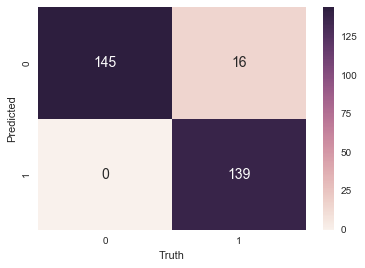

In [270]:
from sklearn.metrics import confusion_matrix
cm_mat = confusion_matrix(Y_test,Y_pred)

accuracy = np.trace(cm_mat)*100.0/len(Y_test)
print 'Test set Accuracy = {:.2f}%'.format(accuracy)

df_temp = pd.DataFrame(cm_mat.flatten()[np.newaxis].T,columns = ['values'])
df_temp = pd.DataFrame(cm_mat.flatten()[np.newaxis].T,columns = ['values'])
plt.figure(figsize = (6,4),dpi=600)
sns.heatmap(cm_mat.T, cbar=True ,annot=True, fmt=',.0f')
plt.xlabel('Truth')
plt.ylabel('Predicted')